In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from pathlib import Path

In [2]:
def generate(
    rng,
    n_subj,
    trial_types,
    item_types,
    study_times,
    n_trial,
    time_lure_strength,
    time_target_strength,
    item_lure_dev,
    item_target_dev,
    criterion,
    s,
    s_time, 
    s_item, 
    s_target, 
    s_lure, 
    s_time_target, 
    s_time_lure, 
    s_item_target, 
    s_item_lure,
):
    n_type = len(trial_types)
    n_item = len(item_types)
    n_time = len(study_times)
    subj_time_dev = rng.normal(loc=0, scale=s_time, size=(n_subj, n_time))
    subj_item_dev = rng.normal(loc=0, scale=s_item, size=(n_subj, n_item))
    subj_target_dev = rng.normal(loc=0, scale=s_target, size=n_subj)
    subj_lure_dev = rng.normal(loc=0, scale=s_lure, size=n_subj)
    subj_time_target_dev = rng.normal(loc=0, scale=s_time_target, size=(n_subj, n_time))
    subj_time_lure_dev = rng.normal(loc=0, scale=s_time_lure, size=(n_subj, n_time))
    subj_item_target_dev = rng.normal(loc=0, scale=s_item_target, size=(n_subj, n_item))
    subj_item_lure_dev = rng.normal(loc=0, scale=s_item_lure, size=(n_subj, n_item))
    d = {
        "subject": [],
        "trial": [],
        "study_time": [],
        "item_type": [],
        "trial_type": [],
        "response": [],
    }
    for i in range(n_subj):
        trial = 0
        for j in range(n_time):
            for k in range(n_item):
                mu_lure = (
                    time_lure_strength[j]
                    + item_lure_dev[k]
                    + subj_time_dev[i, j]
                    + subj_item_dev[i, k]
                    + subj_lure_dev[i]
                    + subj_time_lure_dev[i, j]
                    + subj_item_lure_dev[i, k]
                )
                mu_target = (
                    time_target_strength[j]
                    + item_target_dev[k]
                    + subj_time_dev[i, j]
                    + subj_item_dev[i, k]
                    + subj_target_dev[i]
                    + subj_time_target_dev[i, j]
                    + subj_item_target_dev[i, k]
                )
                lure_strength = rng.normal(loc=mu_lure, scale=s, size=n_trial)
                target_strength = rng.normal(loc=mu_target, scale=s, size=n_trial)
                for l in range(n_type):
                    trial_type = trial_types[l]
                    if trial_type == "target":
                        response = np.where(target_strength > criterion[j], 1, 0)
                    else:
                        response = np.where(lure_strength > criterion[j], 1, 0)
                    for m in range(n_trial):
                        trial += 1
                        d["subject"].append(f"subj{i + 1:02}")
                        d["trial"].append(trial)
                        d["study_time"].append(study_times[j])
                        d["item_type"].append(item_types[k])
                        d["trial_type"].append(trial_type)
                        d["response"].append(response[m])
    df = pl.DataFrame(d)
    return df

In [3]:
rng = np.random.default_rng(1)

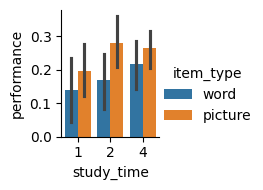

In [4]:
n_subj = 30
trial_types = ["target", "lure"]
item_types = ["word", "picture"]
study_times = [1, 2, 4]
n_trial = 10
time_lure_strength = [0, -0.4, -0.6]
time_target_strength = [1, 1.4, 1.6]
item_lure_dev = [0.1, -0.1]
item_target_dev = [-0.1, 0.1]
criterion = [0.5, 0.6, 0.7]
s = 3
s_time = 0.1
s_item = 0.1
s_target = 0.1
s_lure = 0.1
s_time_target = 0.1
s_time_lure = 0.1
s_item_target = 0.1
s_item_lure = 0.1
df = generate(
    rng,
    n_subj,
    trial_types,
    item_types,
    study_times,
    n_trial,
    time_lure_strength,
    time_target_strength,
    item_lure_dev,
    item_target_dev,
    criterion,
    s,
    s_time, 
    s_item, 
    s_target, 
    s_lure, 
    s_time_target, 
    s_time_lure, 
    s_item_target, 
    s_item_lure,
)
m = (
    df.pivot(
        "trial_type", 
        values="response", 
        index=["subject", "study_time", "item_type"], 
        aggregate_function="mean",
    )
    .with_columns(
        performance=pl.col("target") - pl.col("lure")
    )
)
sns.catplot(m, x="study_time", y="performance", hue="item_type", kind="bar", height=2);

In [5]:
df.write_csv("gen_recog2.csv")

In [6]:
out_dir = Path("data")
for key, group_df in df.group_by("subject"):
    subject = key[0][4:]
    file = out_dir / f"sub-{subject}_beh.npz"
    vars = {}
    for column in group_df.columns:
        col_data = group_df[column].to_numpy()
        vars[column] = col_data
    np.savez(file, **vars)